In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from scipy.interpolate import PchipInterpolator
import matplotlib.pyplot as plt

In [ ]:
class LocationDataset(Dataset):
    def __init__(self, directory):
        self.directory = directory
        self.files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.directory, self.files[idx])
        data = np.loadtxt(file_path).flatten()
        return torch.tensor(data, dtype=torch.float32)

human_dataset = LocationDataset("/content/human_locations")
manga_dataset = LocationDataset("/content/manga_locations")

human_dataloader = DataLoader(human_dataset, batch_size=5, shuffle=True)
manga_dataloader = DataLoader(manga_dataset, batch_size=5, shuffle=True)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(12, 48),
            nn.ReLU(),
            nn.Linear(48, 96),
            nn.ReLU(),
            nn.Linear(96, 48),
            nn.ReLU(),
            nn.Linear(48, 12)
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(12, 48),
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
G_H2M = Generator()
G_M2H = Generator()
D_H = Discriminator()
D_M = Discriminator()

In [ ]:
# Define loss function and optimizers
criterion_GAN = nn.BCELoss()
criterion_cycle = nn.L1Loss()
lr = 0.0002

optimizer_G_H2M = optim.Adam(G_H2M.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_G_M2H = optim.Adam(G_M2H.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_H = optim.Adam(D_H.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_M = optim.Adam(D_M.parameters(), lr=lr, betas=(0.5, 0.999))

# Labels for real and fake data
real_label = torch.ones((5, 1))
fake_label = torch.zeros((5, 1))

# Training loop
num_epochs = 500
for epoch in range(num_epochs):
    for (human_landmarks, manga_landmarks) in zip(human_dataloader, manga_dataloader):
        # Move data to GPU if available
        human_landmarks = human_landmarks
        manga_landmarks = manga_landmarks

        # Train Generators
        optimizer_G_H2M.zero_grad()
        optimizer_G_M2H.zero_grad()

        # GAN loss
        fake_manga = G_H2M(human_landmarks)
        pred_fake = D_M(fake_manga)
        loss_GAN_H2M = criterion_GAN(pred_fake, real_label)

        fake_human = G_M2H(manga_landmarks)
        pred_fake = D_H(fake_human)
        loss_GAN_M2H = criterion_GAN(pred_fake, real_label)

        # Cycle consistency loss
        recovered_human = G_M2H(fake_manga)
        loss_cycle_H2M = criterion_cycle(recovered_human, human_landmarks)

        recovered_manga = G_H2M(fake_human)
        loss_cycle_M2H = criterion_cycle(recovered_manga, manga_landmarks)

        # Total generator loss
        loss_G = loss_GAN_H2M + loss_GAN_M2H + 10.0 * (loss_cycle_H2M + loss_cycle_M2H)
        loss_G.backward()

        optimizer_G_H2M.step()
        optimizer_G_M2H.step()

        # Train Discriminator H
        optimizer_D_H.zero_grad()

        # Real loss
        pred_real = D_H(human_landmarks)
        loss_D_real = criterion_GAN(pred_real, real_label)

        # Fake loss
        pred_fake = D_H(fake_human.detach())
        loss_D_fake = criterion_GAN(pred_fake, fake_label)

        # Total loss
        loss_D_H = (loss_D_real + loss_D_fake) * 0.5
        loss_D_H.backward()
        optimizer_D_H.step()

        # Train Discriminator M
        optimizer_D_M.zero_grad()

        # Real loss
        pred_real = D_M(manga_landmarks)
        loss_D_real = criterion_GAN(pred_real, real_label)

        # Fake loss
        pred_fake = D_M(fake_manga.detach())
        loss_D_fake = criterion_GAN(pred_fake, fake_label)

        # Total loss
        loss_D_M = (loss_D_real + loss_D_fake) * 0.5
        loss_D_M.backward()
        optimizer_D_M.step()

    print(f'Epoch [{epoch+1}/{num_epochs}] Loss G: {loss_G.item()} Loss D_H: {loss_D_H.item()} Loss D_M: {loss_D_M.item()}')

Epoch [1/500] Loss G: 6.942530155181885 Loss D_H: 0.6847553849220276 Loss D_M: 0.6901170015335083
Epoch [2/500] Loss G: 6.399493217468262 Loss D_H: 0.6789907217025757 Loss D_M: 0.6808431148529053
Epoch [3/500] Loss G: 5.969840049743652 Loss D_H: 0.6724528074264526 Loss D_M: 0.6746965646743774
Epoch [4/500] Loss G: 4.6587677001953125 Loss D_H: 0.6660817861557007 Loss D_M: 0.6741712093353271
Epoch [5/500] Loss G: 3.803478240966797 Loss D_H: 0.6612789630889893 Loss D_M: 0.6768313050270081
Epoch [6/500] Loss G: 3.092421770095825 Loss D_H: 0.6613600254058838 Loss D_M: 0.6815621852874756
Epoch [7/500] Loss G: 2.353316068649292 Loss D_H: 0.668260931968689 Loss D_M: 0.6871309876441956
Epoch [8/500] Loss G: 2.0302979946136475 Loss D_H: 0.6789934635162354 Loss D_M: 0.6906068325042725
Epoch [9/500] Loss G: 1.9473379850387573 Loss D_H: 0.6845178604125977 Loss D_M: 0.6909120082855225
Epoch [10/500] Loss G: 2.1186938285827637 Loss D_H: 0.6897039413452148 Loss D_M: 0.6933701038360596
Epoch [11/500] L

In [ ]:
torch.save(G_H2M.state_dict(), 'G_H2M.pth')
torch.save(G_M2H.state_dict(), 'G_M2H.pth')
torch.save(D_H.state_dict(), 'D_H.pth')
torch.save(D_M.state_dict(), 'D_M.pth')

In [ ]:
test_human_dataset = LocationDataset("/content/test_locations")
test_human_dataloader = DataLoader(test_human_dataset, batch_size=1, shuffle=False)
G_H2M.load_state_dict(torch.load('G_H2M.pth'))
G_H2M.eval()
with torch.no_grad():
    for human_locations in test_human_dataloader:
        generated_manga_locations = G_H2M(human_locations)
        print("generated manga locations:", generated_manga_locations)

generated manga locations: tensor([[0.1382, 0.4525, 0.4425, 0.4551, 0.1241, 0.4388, 0.2848, 0.3054, 0.2595,
         0.3046, 0.2957, 0.1619]])


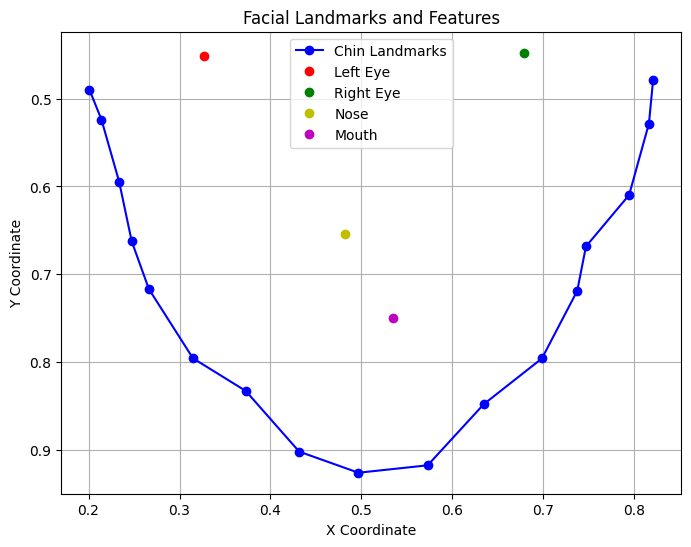

In [ ]:
## Üretilen çıktıları (shapeGAN ve locationGAN) birleştirme için deneme
# Dosyaları okuyup verileri alalım
with open('landmark.txt', 'r') as f:
    landmark_data = f.readlines()

with open('location.txt', 'r') as f:
    location_data = f.readlines()

# Landmark verilerini işleyelim
landmarks = np.array([float(num) for num in landmark_data]).reshape(-1, 2)
x_coords = landmarks[:, 0]
y_coords = landmarks[:, 1]

# Lokasyon verilerini işleyelim
locations = np.array([[float(num) for num in line.split()] for line in location_data])

# Çenenin uç noktalarını ve dip noktasını belirleyelim
left_chin = landmarks[0]
bottom_chin = landmarks[8]
right_chin = landmarks[16]

# Sol göz, sağ göz, burun ve ağız koordinatlarını hesaplayalım
el_l, el_r, el_b = locations[0]
er_l, er_r, er_b = locations[1]
n_l, n_r, n_b = locations[2]
m_l, m_r, m_b = locations[3]

left_eye = (left_chin[0] + el_l, bottom_chin[1] - el_b)
right_eye = (left_chin[0] + er_l, bottom_chin[1] - er_b)
nose = (left_chin[0] + n_l, bottom_chin[1] - n_b)
mouth = (left_chin[0] + m_l, bottom_chin[1] - m_b)

# Grafiği çizelim
plt.figure(figsize=(8, 6))

# Çene noktalarını çizelim
plt.plot(x_coords, y_coords, 'bo-', label='Chin Landmarks')

# Sol göz, sağ göz, burun ve ağız noktalarını çizelim
plt.plot(*left_eye, 'ro', label='Left Eye')
plt.plot(*right_eye, 'go', label='Right Eye')
plt.plot(*nose, 'yo', label='Nose')
plt.plot(*mouth, 'mo', label='Mouth')

# Etiketleri ekleyelim
plt.legend()
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Facial Landmarks and Features')
plt.grid(True)
plt.gca().invert_yaxis()  # Y eksenini ters çevir, çünkü grafikler genellikle yukarıdan aşağıya çizilir

plt.show()